# Aprendizaje No Supervisado:

El **Aprendizaje No Supervisado (Unsupervised Learning)** es una rama del Machine Learning donde el modelo aprende de datos que **no tienen etiquetas ni respuestas predefinidas**. A diferencia del aprendizaje supervisado, donde buscamos predecir un valor $y$ a partir de $X$, aquí nuestro objetivo es entender la geometría y la distribución subyacente de $X$.

## 1. La Filosofía del "No Supervisado"
En este paradigma, la computadora actúa como un explorador. Su tarea es encontrar patrones, similitudes o anomalías que el ojo humano no puede detectar en dimensiones elevadas. Es fundamental en etapas de **Exploratory Data Analysis (EDA)** y como paso previo al modelado predictivo.

### Pilares Teóricos:
* **Densidad y Distancia:** La mayoría de estos algoritmos asumen que los datos que están "cerca" (según métricas como la Distancia Euclidiana o Manhattan) comparten características comunes.
* **Reducción de Información:** El objetivo es pasar de una representación compleja y ruidosa a una más simple y significativa sin perder la esencia de los datos.

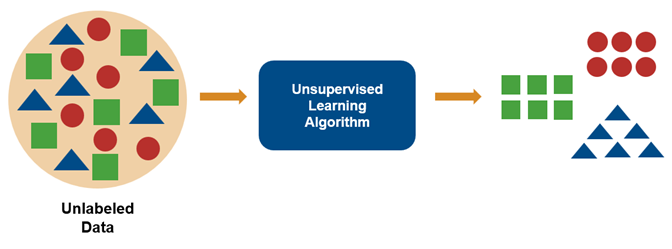

## 2. Taxonomía de los Algoritmos Principales

| Categoría | Objetivo | Algoritmos Clave |
| :--- | :--- | :--- |
| **Clustering** | Agrupar observaciones similares en "cúmulos". | K-Means, DBSCAN, Hierarchical Clustering. |
| **Reducción de Dimensión** | Comprimir variables eliminando redundancia. | PCA, t-SNE, UMAP. |
| **Detección de Anomalías** | Identificar puntos que no siguen la distribución normal. | Isolation Forest, Local Outlier Factor. |
| **Reglas de Asociación** | Descubrir dependencias entre variables (ej. cesta de compra). | Apriori, Eclat. |





## 3. Objetivos de esta Sesión
Hoy aprenderemos a transformar datos "crudos" en información estructurada mediante:
1.  **Segmentación Inteligente:** Diferenciar entre enfoques particionales (K-Means) y conectivos (Jerárquicos).
2.  **Destilación de Varianza:** Usar PCA para "ver" en 2D lo que originalmente está en 13 o más dimensiones.
3.  **Cuantificación del Éxito:** Dado que no hay "acierto/error", aprenderemos a usar la **Inercia** y el **Coeficiente de Silueta**.
4.  **Hibridación:** Cómo usar estos hallazgos para potenciar modelos de regresión y clasificación (Feature Engineering).

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Cargamos el dataset de Vinos (13 características químicas de 3 tipos de cultivadores)
data_wine = load_wine()
X_wine = pd.DataFrame(data_wine.data, columns=data_wine.feature_names)

print(f"Dataset de Vinos cargado: {X_wine.shape[0]} muestras y {X_wine.shape[1]} variables.")
X_wine.head()

Dataset de Vinos cargado: 178 muestras y 13 variables.


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


## 1. K-Means Clustering
El algoritmo **K-Means** busca particionar $n$ observaciones en $k$ grupos. El proceso es iterativo:
1.  Se inicializan $k$ centroides aleatoriamente.
2.  **Asignación:** Cada punto se asigna al centroide más cercano (distancia Euclidiana).
3.  **Actualización:** Se recalcula el centroide como el promedio de todos los puntos asignados a él.

### ¿Cómo elegir K?
* **Método del Codo (Elbow Method):** Basado en la **Inercia** (suma de cuadrados intra-cluster). Buscamos el punto donde la ganancia de información empieza a ser marginal.
* **Coeficiente de Silueta:** Mide qué tan cerca está un punto de su propio cluster en comparación con otros. Rango: [-1, 1]. Un valor alto indica una buena estructura.

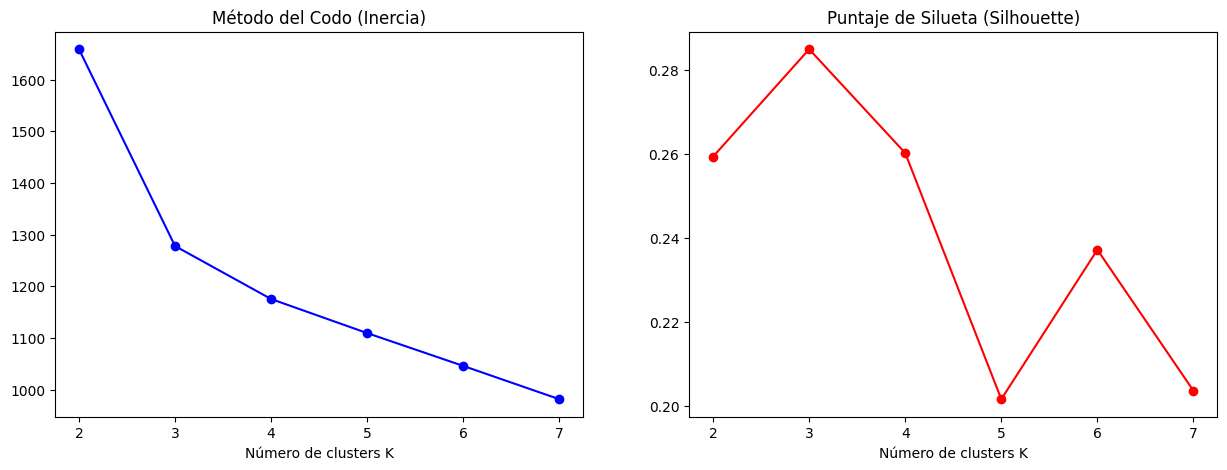

In [2]:
# El escalado es vital: las variables de vino tienen rangos muy distintos (ej. Magnesio vs Fenoles)
scaler = StandardScaler()
X_wine_scaled = scaler.fit_transform(X_wine)

# Buscamos el K óptimo
inercias = []
siluetas = []
rango_k = range(2, 8)

for k in rango_k:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_wine_scaled)
    inercias.append(km.inertia_)
    siluetas.append(silhouette_score(X_wine_scaled, labels))

# Visualización dual
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(rango_k, inercias, 'bo-')
ax1.set_title('Método del Codo (Inercia)')
ax1.set_xlabel('Número de clusters K')

ax2.plot(rango_k, siluetas, 'ro-')
ax2.set_title('Puntaje de Silueta (Silhouette)')
ax2.set_xlabel('Número de clusters K')
plt.show()

# Ejecutamos con K=3 (que sabemos que es la estructura real del dataset)
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
X_wine['cluster_kmeans'] = kmeans_final.fit_predict(X_wine_scaled)

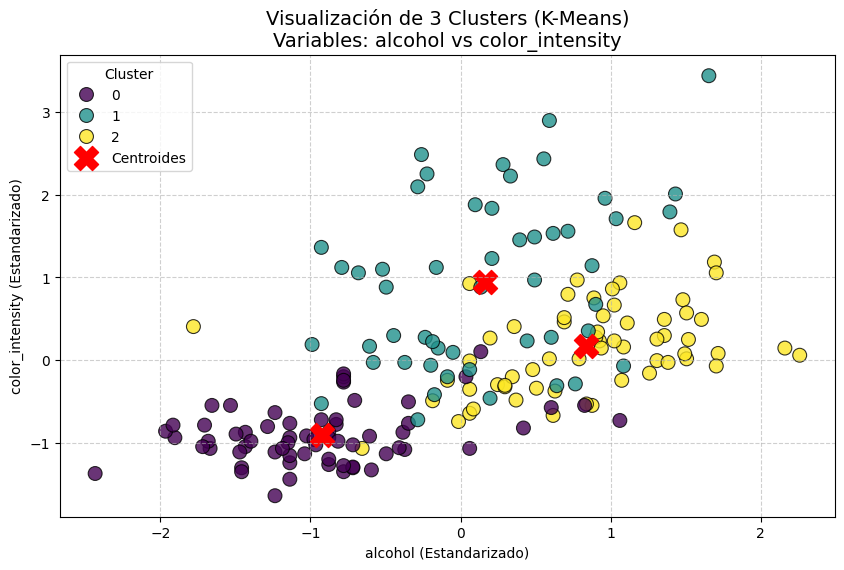

In [3]:
# Elegimos dos variables representativas para la visualización 2D simple
# Variable 0: Alcohol, Variable 9: Color Intensity
var_x = 0
var_y = 9

# Configuración del modelo final con K=3
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_3 = kmeans_3.fit_predict(X_wine_scaled)

# Visualización
plt.figure(figsize=(10, 6))

# Graficar los puntos coloreados por su cluster
sns.scatterplot(
    x=X_wine_scaled[:, var_x],
    y=X_wine_scaled[:, var_y],
    hue=labels_3,
    palette='viridis',
    s=100,
    edgecolor='black',
    alpha=0.8
)

# Graficar los centroides
centroids = kmeans_3.cluster_centers_
plt.scatter(
    centroids[:, var_x],
    centroids[:, var_y],
    c='red',
    s=300,
    marker='X',
    label='Centroides'
)

plt.title(f'Visualización de 3 Clusters (K-Means)\nVariables: {data_wine.feature_names[var_x]} vs {data_wine.feature_names[var_y]}', fontsize=14)
plt.xlabel(f'{data_wine.feature_names[var_x]} (Estandarizado)')
plt.ylabel(f'{data_wine.feature_names[var_y]} (Estandarizado)')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Variables detectadas con mayor poder de separación:
1. flavanoids (Varianza inter-cluster: 1.21)
2. od280/od315_of_diluted_wines (Varianza inter-cluster: 1.17)


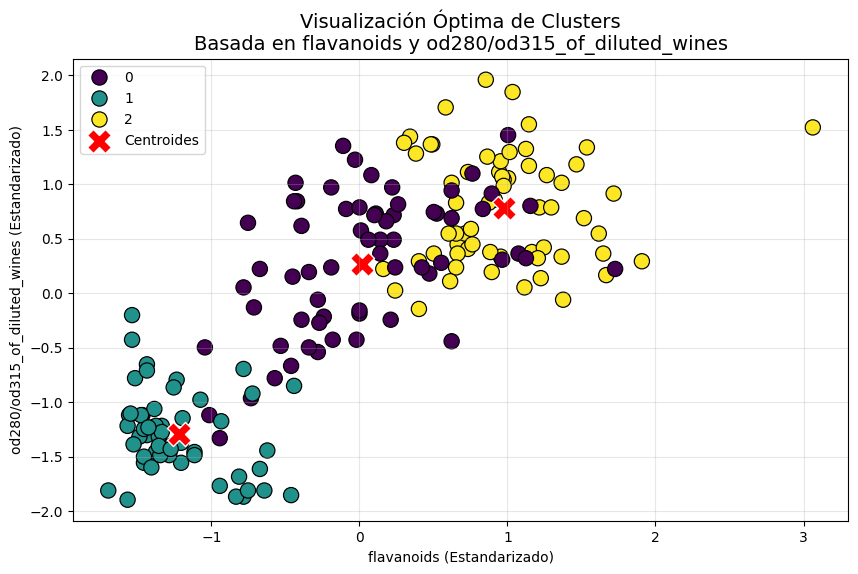

In [4]:
# 1. Calculamos los promedios de cada variable por cada cluster
# Esto nos dice qué tanto varía cada característica entre grupos
df_temp = pd.DataFrame(X_wine_scaled, columns=data_wine.feature_names)
df_temp['cluster'] = labels_3

# Calculamos la varianza de los promedios entre clusters
# Las variables con mayor varianza entre promedios son las que más "separan"
cluster_means = df_temp.groupby('cluster').mean()
separation_score = cluster_means.var().sort_values(ascending=False)

# Elegimos las dos mejores
top_vars = separation_score.head(2).index.tolist()
var_x_name = top_vars[0]
var_y_name = top_vars[1]

# Obtenemos sus índices para el array escalado
idx_x = data_wine.feature_names.index(var_x_name)
idx_y = data_wine.feature_names.index(var_y_name)

print(f"Variables detectadas con mayor poder de separación:")
print(f"1. {var_x_name} (Varianza inter-cluster: {separation_score.iloc[0]:.2f})")
print(f"2. {var_y_name} (Varianza inter-cluster: {separation_score.iloc[1]:.2f})")

# 2. Graficamos con las variables óptimas
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=X_wine_scaled[:, idx_x],
    y=X_wine_scaled[:, idx_y],
    hue=labels_3,
    palette='viridis',
    s=120,
    edgecolor='black'
)

# Centroides para estas variables
plt.scatter(
    kmeans_3.cluster_centers_[:, idx_x],
    kmeans_3.cluster_centers_[:, idx_y],
    c='red', s=300, marker='X', label='Centroides', edgecolors='white'
)

plt.title(f'Visualización Óptima de Clusters\nBasada en {var_x_name} y {var_y_name}', fontsize=14)
plt.xlabel(f'{var_x_name} (Estandarizado)')
plt.ylabel(f'{var_y_name} (Estandarizado)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 2. Clustering Jerárquico (Agglomerative)
A diferencia de K-Means, este enfoque construye una jerarquía de grupos de abajo hacia arriba (Bottom-up).
* Comienza considerando cada punto como un cluster individual.
* En cada paso, fusiona los dos clusters más cercanos.
* **Linkage (Enlace):** Define cómo se mide la distancia entre grupos (Ward, Complete, Average).

**Ventaja:** No requiere definir $K$ a priori y permite visualizar la estructura de los datos mediante un **Dendrograma**.

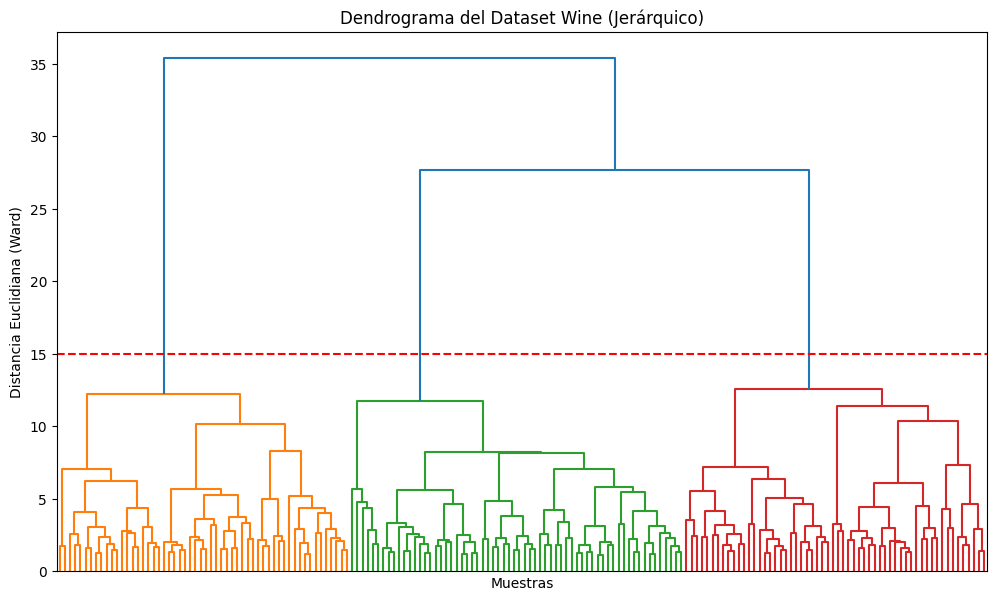

In [15]:
# Calculamos la matriz de enlace usando los datos escalados del vino
Z = linkage(X_wine_scaled, method='ward')

plt.figure(figsize=(12, 7))
# Ocultamos las etiquetas de las hojas para evitar el solapamiento, manteniendo la estructura completa del dendrograma
dendrogram(
    Z,
    no_labels=True,          # No mostrar las etiquetas de las hojas
    color_threshold=15       # Mantener el umbral de color para visualizar los clusters
)
plt.title('Dendrograma del Dataset Wine (Jerárquico)')
plt.xlabel('Muestras')
plt.ylabel('Distancia Euclidiana (Ward)')
plt.axhline(y=15, color='r', linestyle='--') # Línea de corte para obtener 3 clusters
plt.show()

# Aplicamos la etiqueta al dataframe
hc = AgglomerativeClustering(n_clusters=3)
X_wine['cluster_hierarchical'] = hc.fit_predict(X_wine_scaled)

## 3. Principal Component Analysis (PCA)

¿Cómo vemos 13 dimensiones en una pantalla 2D? Usamos PCA para proyectar los datos en los ejes de mayor varianza.

PCA es una técnica de transformación lineal que busca las direcciones (Componentes Principales) de máxima varianza en los datos.
* **PC1:** Captura la mayor variabilidad posible.
* **PC2:** Es ortogonal a PC1 y captura la mayor varianza restante.

Es fundamental para:
1.  **Visualización:** Pasar de $N$ dimensiones a 2D o 3D.
2.  **Eliminar Ruido:** Descartar componentes con baja varianza explicada.
3.  **Mitigar la "Maldición de la Dimensionalidad".**

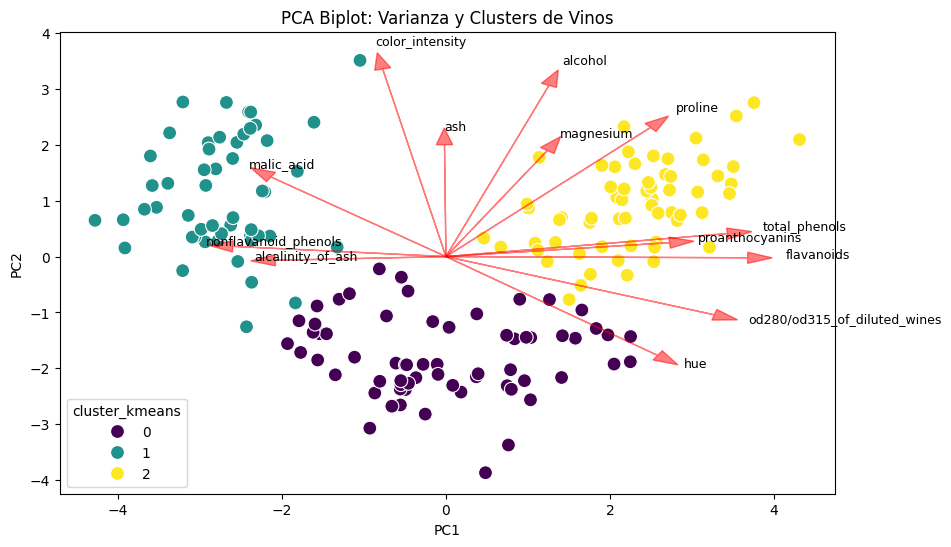

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_wine_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=X_wine['cluster_kmeans'], palette='viridis', s=100)

# Añadimos los "loadings" (importancia de las variables)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, feature in enumerate(data_wine.feature_names):
    plt.arrow(0, 0, loadings[i, 0]*4, loadings[i, 1]*4, color='red', alpha=0.5, head_width=0.2)
    plt.text(loadings[i, 0]*4.5, loadings[i, 1]*4.5, feature, fontsize=9)

plt.title('PCA Biplot: Varianza y Clusters de Vinos')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [7]:
import plotly.express as px

# 1. Realizar PCA con 3 componentes
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_wine_scaled)

# Crear un DataFrame para Plotly
df_pca_3d = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca_3d['cluster_kmeans'] = X_wine['cluster_kmeans']

# 2. Visualización 3D interactiva con Plotly
fig = px.scatter_3d(
    df_pca_3d,
    x='PC1',
    y='PC2',
    z='PC3',
    color='cluster_kmeans',
    symbol='cluster_kmeans',
    color_continuous_scale=px.colors.qualitative.Vivid,
    title='PCA 3D: Clusters de Vinos con PC1, PC2 y PC3',
    labels={'PC1': f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)',
            'PC2': f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)',
            'PC3': f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)'}
)

fig.update_layout(
    scene_aspectmode='cube',
    width=1000,
    height=700,
    legend=dict(
        x=-0.05,
        y=1,
        xanchor='left',
        yanchor='top'
    ),
    margin=dict(r=200) # Aumentar el margen derecho para dar suficiente espacio a la leyenda
)
fig.show()

print(f"Varianza explicada por PC1: {pca_3d.explained_variance_ratio_[0]*100:.1f}%")
print(f"Varianza explicada por PC2: {pca_3d.explained_variance_ratio_[1]*100:.1f}%")
print(f"Varianza explicada por PC3: {pca_3d.explained_variance_ratio_[2]*100:.1f}%")

Varianza explicada por PC1: 36.2%
Varianza explicada por PC2: 19.2%
Varianza explicada por PC3: 11.1%


## 6. Interpretación de PCA: ¿Qué variables importan?
PCA a menudo se critica por ser una "caja negra", pero podemos abrirla analizando los **loadings** (cargas).
* Los loadings indican la correlación entre las variables originales y los Componentes Principales.
* Esto nos permite saber qué variables contribuyen más a la varianza capturada.

**Concepto Clave:** Si el Componente 1 tiene un loading alto para "Alcohol" y "Flavonoides" en el dataset de vino, sabemos que ese eje representa la "estructura química compleja" del vino.

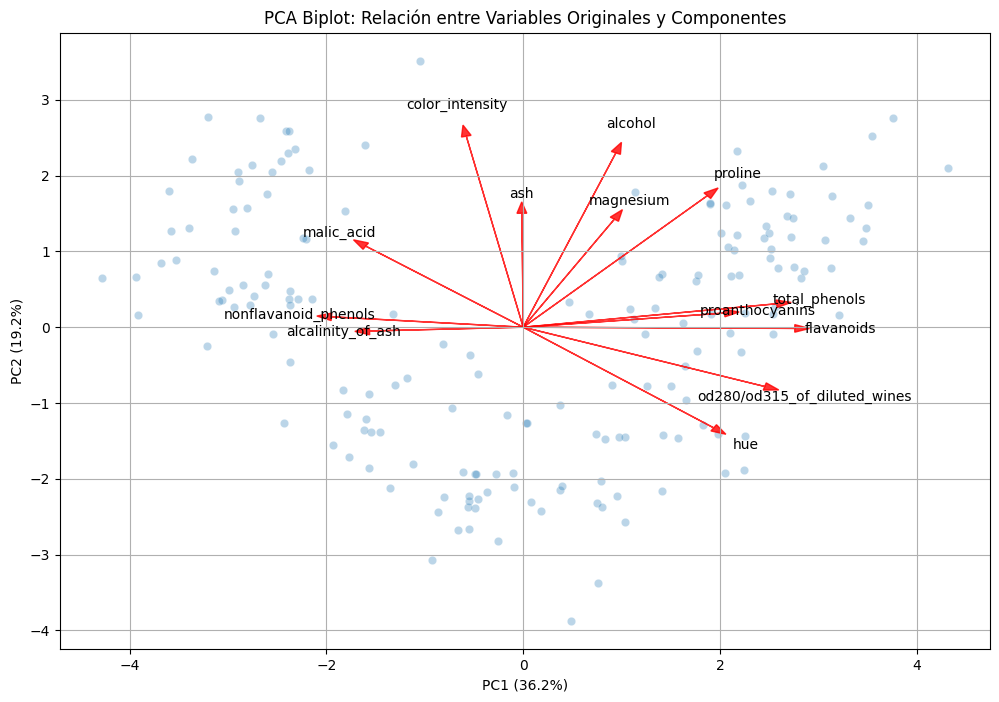

Top 5 variables que más influyen en el PC1:
color_intensity    0.088617
alcohol            0.144329
proline            0.286752
ash                0.002051
magnesium          0.141992
Name: PC1, dtype: float64
Top 5 variables que más influyen en el PC2:
color_intensity    0.529996
alcohol            0.483652
proline            0.364903
ash                0.316069
magnesium          0.299634
Name: PC2, dtype: float64


In [17]:
# Entrenamos PCA con el dataset completo
pca_interp = PCA(n_components=2)
X_pca_interp = pca_interp.fit_transform(X_wine_scaled)

# Obtener los componentes (loadings)
loadings = pca_interp.components_.T * np.sqrt(pca_interp.explained_variance_)

# Visualización de la importancia de variables (Loading Plot)
plt.figure(figsize=(12, 8))

# Dibujamos los puntos de los datos
sns.scatterplot(x=X_pca_interp[:, 0], y=X_pca_interp[:, 1], alpha=0.3)

# Dibujamos las flechas de las variables originales
features = data_wine.feature_names # Corrected to use original feature names
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3, color='red', alpha=0.8, head_width=0.1)
    plt.text(loadings[i, 0]*3.5, loadings[i, 1]*3.5, feature, color='black', ha='center', va='center', fontsize=10)

plt.xlabel(f"PC1 ({pca_interp.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca_interp.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA Biplot: Relación entre Variables Originales y Componentes")
plt.grid(True)
plt.show()

# Tabla de importancia
importance_df = pd.DataFrame(
    np.abs(pca_interp.components_),
    columns=features,
    index=['PC1', 'PC2']
).T.sort_values(by='PC1', ascending=False)

importance_df = pd.DataFrame(
    np.abs(pca_interp.components_),
    columns=features,
    index=['PC1', 'PC2']
).T.sort_values(by='PC2', ascending=False)

print("Top 5 variables que más influyen en el PC1:")
print(importance_df['PC1'].head(5))
print("Top 5 variables que más influyen en el PC2:")
print(importance_df['PC2'].head(5))

## 4. Aprendizaje No Supervisado al Servicio del Supervisado
Una técnica avanzada de **Feature Engineering** consiste en utilizar algoritmos no supervisados para generar nuevas variables que alimenten a un clasificador o regresor.

**Estrategia:**
1.  Realizar un Clustering sobre los datos de entrenamiento.
2.  Tomar la etiqueta del cluster como una variable categórica nueva.
3.  Entrenar un modelo (ej. Regresion logística) usando las variables originales + la pertenencia al cluster.
Esto permite al modelo supervisado entender "regiones" de datos que el algoritmo no supervisado ya identificó como similares.

## 4. Feature Engineering: Superando la Linealidad

En este experimento demostraremos cómo el Clustering puede salvar a un modelo simple.
* **Problema:** Los modelos lineales (como la Regresión Logística) solo pueden separar datos con "líneas rectas".
* **Solución No Supervisada:** El Clustering identifica grupos naturales (esferas, nubes). Si le entregamos estos grupos al modelo, este puede entender fronteras complejas.

**Dataset:** Wine (13 variables químicas).
**Modelo:** Regresión Logística.

## ¿Qué estamos analizando realmente?

### 1. El Target
En el **Wine Dataset**, el target ($y$) representa el **cultivar** (el tipo de uva/viñedo). Existen 3 clases (0, 1, 2) que corresponden a tres productores diferentes en la misma región de Italia. Aunque el modelo no supervisado no ve estas etiquetas, nuestro objetivo es ver si la química del vino (alcohol, magnesio, flavonoides, etc.) es suficiente para agruparlos correctamente.

### 2. Selección del número de Clusters ($K$)
No elegimos $K=3$ solo porque existan 3 clases. En la vida real, no conoceríamos el target. Por eso, usamos el **Análisis de Silueta** y la **Inercia** para demostrar que 3 es el número natural donde los datos se agrupan mejor.



En este experimento final, demostraremos cómo el clustering puede ayudar a un modelo lineal (**Regresión Logística**) a entender fronteras que originalmente no puede ver.

**La Estrategia:**
1.  **Variables para Clustering:** Usaremos `Color Intensity` y `Alcohol`. Estas variables son críticas pero tienen mucha superposición.
2.  **Sustitución Inteligente:** Crearemos clusters a partir de estas dos variables y las reemplazaremos por sus etiquetas (One-Hot Encoded).
3.  **Objetivo:** Mejorar la precisión del modelo base simplificando la relación entre color y alcohol.

In [9]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans

# 1. Carga y preparación
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalado
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# 2. Modelo Base
lr_base = LogisticRegression(max_iter=1000)
lr_base.fit(X_train_std, y_train)
acc_base = lr_base.score(X_test_std, y_test)

print(f"Precisión Modelo Base (Original): {acc_base:.4f}")

Precisión Modelo Base (Original): 0.9815


In [10]:
wine_df_with_target = X_wine.copy()
wine_df_with_target['target'] = data_wine.target

print("Dataset de Vinos con la variable target:")
display(wine_df_with_target.head())

Dataset de Vinos con la variable target:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,cluster_kmeans,cluster_hierarchical,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,2,2,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,2,2,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,2,2,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,2,2,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,2,2,0


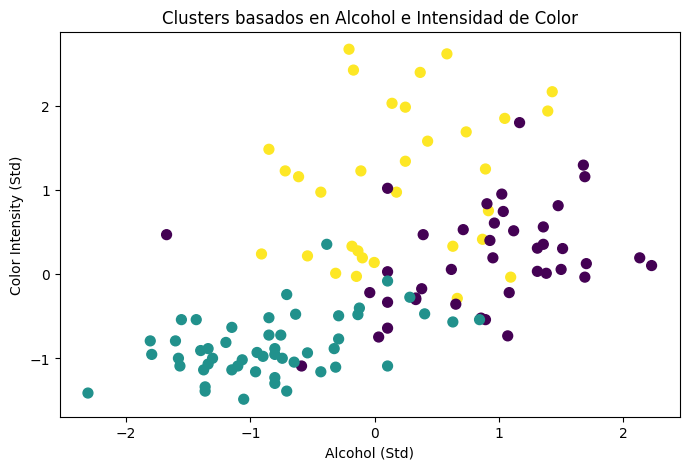

In [19]:
# 3. Escogemos dos variables para el cluster
# 'alcohol' y 'color_intensity' suelen tener mucha varianza
vars_to_cluster = ['alcohol', 'color_intensity', 'magnesium', 'flavanoids', 'ash']
idx_vars = [X.columns.get_loc(c) for c in vars_to_cluster]

# Solo escalamos estas dos para el cluster
scaler_2v = StandardScaler()
train_2v = scaler_2v.fit_transform(X_train[vars_to_cluster])
test_2v = scaler_2v.transform(X_test[vars_to_cluster])

# Aplicamos K-Means (K=3 porque sabemos que hay 3 tipos de vino)
km = KMeans(n_clusters=3, random_state=42, n_init=10)
c_train = km.fit_predict(train_2v)
c_test = km.predict(test_2v)

# Mapa de los clusters creados
plt.figure(figsize=(8, 5))
plt.scatter(train_2v[:, 0], train_2v[:, 1], c=c_train, cmap='viridis', s=50)
plt.title("Clusters basados en Alcohol e Intensidad de Color")
plt.xlabel("Alcohol (Std)")
plt.ylabel("Color Intensity (Std)")
plt.show()

In [20]:
# 4. One-Hot Encoding del Cluster
ohe = OneHotEncoder(sparse_output=False)
train_ohe = ohe.fit_transform(c_train.reshape(-1, 1))
test_ohe = ohe.transform(c_test.reshape(-1, 1))

# 5. Dataset de Sustitución
# Quitamos las 2 variables originales y ponemos los 3 clusters (dummies)
X_train_final = np.hstack((np.delete(X_train_std, idx_vars, axis=1), train_ohe))
X_test_final = np.hstack((np.delete(X_test_std, idx_vars, axis=1), test_ohe))

# 6. Re-entrenamiento
lr_final = LogisticRegression(max_iter=1000)
lr_final.fit(X_train_final, y_train)
acc_final = lr_final.score(X_test_final, y_test)

print(f"--- COMPARATIVA FINAL ---")
print(f"Precisión Base: {acc_base:.4f}")
print(f"Precisión con Clusters: {acc_final:.4f}")
print(f"Diferencia: {acc_final - acc_base:.4f}")

if acc_final > acc_base:
    print("¡ÉXITO! El clustering mejoró la capacidad de clasificación.")
else:
    print("La precisión se mantuvo, lo cual indica una compresión eficiente.")

--- COMPARATIVA FINAL ---
Precisión Base: 0.9815
Precisión con Clusters: 1.0000
Diferencia: 0.0185
¡ÉXITO! El clustering mejoró la capacidad de clasificación.


## Resumen Final
1.  **Escalado:** Sin `StandardScaler`, el clustering fallará porque las variables con rangos grandes dominarán la distancia.
2.  **Validación:** La inercia nos da el "codo", pero la silueta nos da la calidad de la separación.
3.  **PCA no es solo visual:** Es una herramienta de diagnóstico. Si dos variables apuntan en la misma dirección en el Biplot, están altamente correlacionadas.
4.  **Flujo recomendado:** Limpiar outliers $\rightarrow$ Escalar $\rightarrow$ Reducir dimensión (PCA) $\rightarrow$ Clustering $\rightarrow$ Usar clusters como nuevas Features.